## Interface height vs layer thickness gradients

In models with large scale bottom slope changes the bottom layer thickness ends up incorporating this information in it. While this bottom slope probably impacts the eddy fluxes, it does not seem to be the case that this has a first order effect. 

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [3]:
import sys
sys.path.append('../modules/')

In [4]:
%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2024-10-04 21:06:10.943195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 21:06:10.943229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 21:06:10.944628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We will run a few experiment configs. All with non-dim outputs. The goal is to compare the impact of inputs.

1. Inputs: norm vel gradients, thickness gradients
2. Inputs: norm vel gradients, interface slope
3. Inputs: norm vel gradients, thickness gradients, inteface slopes

In [5]:
# Experiment
experiment_config= {'simulation_names':['P2L'], 
                    'filter_scales':['50','100','200','400'],
                    'window_size':3, 
                    
                    'input_channels' : ['dudx_widened',  
                                        'dvdx_widened', 
                                        'dudy_widened',
                                        'dvdy_widened',
                                        'dhdx_widened',
                                        'dhdy_widened',
                                        'dedx_middle_widened',
                                        'dedy_middle_widened',
                                        'filter_scale'],
                    
                    'output_channels' : ['uphp',
                                         'vphp'],
                    
                    'coeff_channels'  : [], 
        
                    'train_time_range': slice(0, 640),
                    'test_time_range' : slice(-64, None),
                    'num_train_batches': 37, 
                    'num_test_batches' : 5, 

                    'num_inputs': 8*9 + 1, 
                    'network_shape': [36, 36, 2],

                    'exp_ckpt_save_dir': '/home/jovyan/mesoscale_buoyancy_param_ML/ML_checkpoints/test_ckpt'
                    
            }

experiment_config['all_ml_variables'] = (experiment_config['input_channels'] + 
                                           experiment_config['output_channels'] +
                                           experiment_config['coeff_channels'])

experiment_config['num_inputs'] = (len(experiment_config['input_channels']) - 1)*experiment_config['window_size']**2 + 1

In [6]:

#DT = datasets.SimulationData(simulation_names=['P2L', 'DG'], filter_scales=['50','100','200','400'])
DT = datasets.SimulationData(simulation_names=experiment_config['simulation_names'], 
                             filter_scales=experiment_config['filter_scales'], 
                             window_size = experiment_config['window_size'])

ML_DT_train = datasets.MLXarrayDataset(simulation_data=DT, 
                                       all_ml_variables=experiment_config['all_ml_variables'],
                                       time_range=experiment_config['train_time_range'],
                                       num_batches = experiment_config['num_train_batches'])

ML_DT_test = datasets.MLXarrayDataset(simulation_data=DT,
                                      all_ml_variables=experiment_config['all_ml_variables'],
                                      time_range=experiment_config['test_time_range'],
                                      num_batches = experiment_config['num_test_batches'])

Will load : 1.11232 gb into memory.
load took: 39.6390 seconds
Will load : 0.111232 gb into memory.
load took: 5.2128 seconds


In [7]:
batch_xr = ML_DT_train.ml_batches[0]

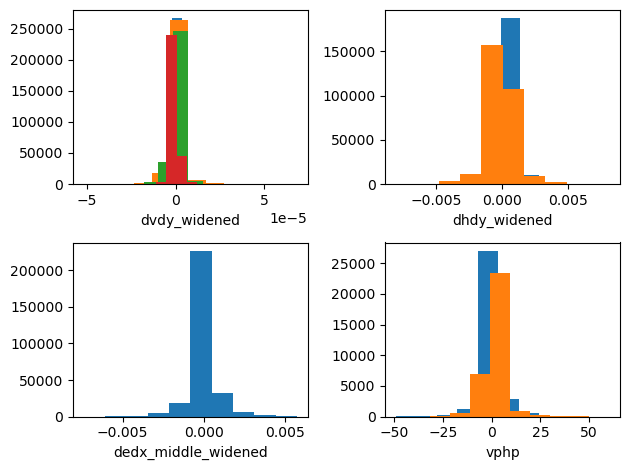

In [8]:
plt.subplot(221)
batch_xr[experiment_config['input_channels'][0]].plot.hist();
batch_xr[experiment_config['input_channels'][1]].plot.hist();
batch_xr[experiment_config['input_channels'][2]].plot.hist();
batch_xr[experiment_config['input_channels'][3]].plot.hist();

plt.subplot(222)
batch_xr[experiment_config['input_channels'][4]].plot.hist();
batch_xr[experiment_config['input_channels'][5]].plot.hist();

plt.subplot(223)
batch_xr[experiment_config['input_channels'][6]].plot.hist();

plt.subplot(224)
batch_xr[experiment_config['output_channels'][0]].plot.hist();
batch_xr[experiment_config['output_channels'][1]].plot.hist();

plt.tight_layout()

In [9]:
batch_xr.std()

<xarray.Dataset> Size: 80B
Dimensions:              ()
Data variables:
    dudx_widened         float64 8B 1.909e-06
    dvdx_widened         float64 8B 3.399e-06
    dudy_widened         float64 8B 3.105e-06
    dvdy_widened         float64 8B 1.902e-06
    dhdx_widened         float64 8B 0.000821
    dhdy_widened         float64 8B 0.001092
    dedx_middle_widened  float64 8B 0.0008201
    dedy_middle_widened  float64 8B 0.00104
    filter_scale         float64 8B 1.34e+05
    uphp                 float32 4B 5.6
    vphp                 float32 4B 5.185

In [10]:
# Define the variables and assign normalizations 

normalize_data_dic = {
    'dudx': ([], 1e-6),  # scalar value
    'dvdx': ([], 1e-6),
    'dudy': ([], 1e-6),
    'dvdy': ([], 1e-6),
    'dhdx': ([], 1e-3),
    'dhdy': ([], 1e-3),
    'dedx_middle': ([], 1e-3),
    'dedy_middle': ([], 1e-3),
    'filter_scale': ([], 140e3),
    'uphp': ([], 4.),
    'vphp': ([], 4.),

    'dudx_nondim': ([], 1.),  # scalar value
    'dvdx_nondim': ([], 1.),
    'dudy_nondim': ([], 1.),
    'dvdy_nondim': ([], 1.),
    
    'uphp_nondim': ([], 1e-5),
    'vphp_nondim': ([], 1e-5),

    'dudx_widened': ([], 1e-6),  # scalar value
    'dvdx_widened': ([], 1e-6),
    'dudy_widened': ([], 1e-6),
    'dvdy_widened': ([], 1e-6),
    'dhdx_widened': ([], 1e-3),
    'dhdy_widened': ([], 1e-3),
    'dedx_middle_widened': ([], 1e-3),
    'dedy_middle_widened': ([], 1e-3),
    'dhdx_widened_rotated': ([], 1e-3),
    'dhdy_widened_rotated': ([], 1e-3),
    
    'dudx_widened_rotated_nondim': ([], 1e-1),  # scalar value
    'dvdx_widened_rotated_nondim': ([], 1e-1),
    'dudy_widened_rotated_nondim': ([], 1e-1),
    'dvdy_widened_rotated_nondim': ([], 1e-1),
    'dhdx_widened_rotated_nondim': ([], 1e-1),
    'dhdy_widened_rotated_nondim': ([], 1e-1),
    'uphp_rotated_nondim': ([], 1e-5),
    'vphp_rotated_nondim': ([], 1e-5),
}

ds_norm = xr.Dataset(normalize_data_dic)

In [11]:
train_ML_data = datasets.MLJAXDataset(ML_DT_train, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'], 
                                      ds_norm=ds_norm)

test_ML_data = datasets.MLJAXDataset(ML_DT_test, 
                                      input_channels=experiment_config['input_channels'], 
                                      output_channels=experiment_config['output_channels'], 
                                      coeff_channels=experiment_config['coeff_channels'],
                                      ds_norm=ds_norm)

ML_data_combo = {'train_data':train_ML_data, 'test_data':test_ML_data}

In [12]:
for batch_out in ML_data_combo['train_data'].get_batches():
    print("Input (X) batch shape:", batch_out['X'].shape)
    print("Output (y) batch shape:", batch_out['y'].shape)
    
    # If you want to view a sample of the data
    #print("Sample X:", batch_out['X'])  # First sample of the batch
    #print("Sample y:", batch_out['y'])  # Corresponding label/target
    break  # Remove break to print more batches

Input (X) batch shape: (32380, 73)
Output (y) batch shape: (32380, 2)


In [13]:
num_in = batch_out['X'].shape[-1]
num_in

73

In [14]:
ANN_model = ML_classes.PointwiseANN(num_in = experiment_config['num_inputs'],
                                    shape = experiment_config['network_shape']) 

In [15]:
ANN_model.count_parameters()

4070


In [16]:
regress_sys = ML_classes.AnnRegressionSystem(ANN_model)

In [17]:
%%time 
regress_sys.train_system(ML_data_combo, num_epoch=41, print_freq=2)

At epoch 1. Train loss :  1.0024018690392777 , Test loss: 0.5652387022972107
At epoch 3. Train loss :  0.3818512397843438 , Test loss: 0.3228801071643829
At epoch 5. Train loss :  0.2748750971781241 , Test loss: 0.2407289206981659
At epoch 7. Train loss :  0.22287606991626122 , Test loss: 0.19806285500526427
At epoch 9. Train loss :  0.19694270999044985 , Test loss: 0.18487756550312043
At epoch 11. Train loss :  0.1813295813831123 , Test loss: 0.16955367624759674
At epoch 13. Train loss :  0.17195823103994937 , Test loss: 0.16094953715801238
At epoch 15. Train loss :  0.15629863618193446 , Test loss: 0.15128640234470367
At epoch 17. Train loss :  0.15218640662528374 , Test loss: 0.14863323271274567
At epoch 19. Train loss :  0.14460899982903455 , Test loss: 0.13813600838184356
At epoch 21. Train loss :  0.13745590359778018 , Test loss: 0.1376433104276657
At epoch 23. Train loss :  0.13093017081956607 , Test loss: 0.12479151934385299
At epoch 25. Train loss :  0.12926021359256795 , Test

Clearly and obviously this loss is a function of the normalization that is used. 

In [21]:
regress_sys.save_checkpoint(experiment_config['exp_ckpt_save_dir'])

### Model evaluation 

In [22]:
test_eval = evaluation.EvalSystem(simulation_data=DT,
                                 input_channels=experiment_config['input_channels'],
                                 output_channels=experiment_config['output_channels'], 
                                 coeff_channels=experiment_config['coeff_channels'], 
                                 ds_norm_factors=ds_norm,
                                 eval_time_slice=slice(1000, 1010), 
                                 num_inputs=experiment_config['num_inputs'], 
                                 shape=experiment_config['network_shape'], 
                                 ckpt_dir=experiment_config['exp_ckpt_save_dir'])


In [23]:
# Spin up 
test_eval.read_ann_regression_model()
test_eval.read_eval_data()
test_eval.predict()

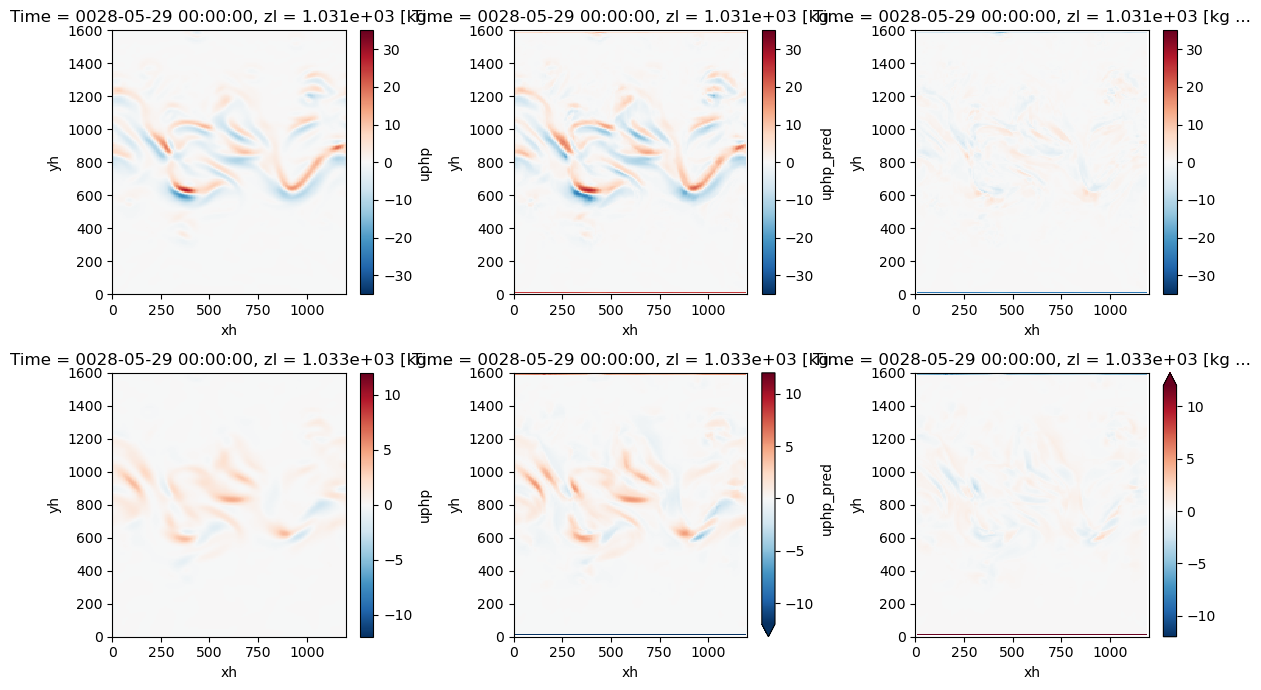

In [25]:
exp = experiment_config['simulation_names'][0]
scale = '50'

plt.figure(figsize=(12, 7))

vmin=-35
zl_choice = 0

plt.subplot(231)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(232)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred'].isel(Time=0, zl=0).plot(vmin=vmin)

plt.subplot(233)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][zl_choice]+'_pred']).isel(Time=0, zl=0).plot(vmin=vmin)


vmin=-12 
zl_choice = 1

plt.subplot(234)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(235)
test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred'].isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.subplot(236)
(test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]] - 
 test_eval.eval_datatree.ml_dataset[exp][scale][experiment_config['output_channels'][0]+'_pred']).isel(Time=0, zl=zl_choice).plot(vmin=vmin)

plt.tight_layout()

In [26]:
# Pick some region away from boundaries to do that stats 

In [27]:
test_eval.calc_time_hor_space_metrics(yh_region=slice(200, 1400))
test_eval.calc_time_hor_space_metrics(var='vphp', yh_region=slice(200, 1400))

In [28]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', R2 for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_R2_all_space_time.values))
        print(exp+' '+scale+', R2 for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_R2_all_space_time.values))

P2L 50, R2 for uphp is 0.856366146462178
P2L 50, R2 for vphp is 0.8199486516420399
P2L 100, R2 for uphp is 0.9341988278756292
P2L 100, R2 for vphp is 0.9304087326154827
P2L 200, R2 for uphp is 0.9609784947163948
P2L 200, R2 for vphp is 0.953594023302977
P2L 400, R2 for uphp is 0.931884082497445
P2L 400, R2 for vphp is 0.8789382651988245


In [29]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', corr for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_corr_all_space_time.values))
        print(exp+' '+scale+', corr for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_corr_all_space_time.values))

P2L 50, corr for uphp is 0.9503681532770166
P2L 50, corr for vphp is 0.9322122538330689
P2L 100, corr for uphp is 0.9680531351404632
P2L 100, corr for vphp is 0.9652786167876537
P2L 200, corr for uphp is 0.9801951947206827
P2L 200, corr for vphp is 0.9769288711290727
P2L 400, corr for uphp is 0.9645320699821299
P2L 400, corr for vphp is 0.9385034822970614


In [30]:
for exp in experiment_config['simulation_names']: 
    for scale in experiment_config['filter_scales']: 
        print(exp+' '+scale+', mse for uphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].uphp_mse_all_space_time.values))
        print(exp+' '+scale+', mse for vphp is '+ str(test_eval.eval_datatree.ml_dataset[exp][scale].vphp_mse_all_space_time.values))

P2L 50, mse for uphp is 0.8691893523160149
P2L 50, mse for vphp is 1.3441411234974463
P2L 100, mse for uphp is 2.082390073149015
P2L 100, mse for vphp is 2.5924456725068747
P2L 200, mse for uphp is 2.6883578953173095
P2L 200, mse for vphp is 3.4240764901177556
P2L 400, mse for uphp is 4.518542080819184
P2L 400, mse for vphp is 6.40040725263024


Note that the MSE values here are a bit larger than what we had in loss. This is for 2 reasons (i) There is a factor of 4 in normalization, and (ii) we divided the MSE in training by 2 out of convention. 